In [222]:
!pip install roboflow

In [223]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch import optim
import matplotlib.pyplot as plt
from roboflow import Roboflow

In [224]:
rf = Roboflow(api_key="UinOpQSEUeMiovI9b24c")
project = rf.workspace("visiontuner-fpebk").project("classification-uowwo")
dataset = project.version(1).download("folder")


loading Roboflow workspace...
loading Roboflow project...


In [225]:
train_transform = transforms.Compose([
    transforms.Resize((300, 300)), #The Resize transform makes sure all images are of the same size.
    transforms.RandomRotation(10),     # RandomRotation, RandomHorizontalFlip, and RandomVerticalFlip introduce variations in the training data
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(), #transforms the images into PyTorch tensors
])

test_transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
])

In [226]:

train_dir = "/content/classification-1/train"
test_dir = "/content/classification-1/test"
val_dir = "/content/classification-1/valid"
#load the datasets using ImageFolder to organize the images into classes based on their folder names
#This makes it easier to handle the data during training
val_dataset = datasets.ImageFolder(val_dir, transform=test_transform)
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)


In [227]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=10, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=10, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10, shuffle=False)

In [228]:
#Print the shape of each image along with its label to understand how the data is organized and labeled across the datasets
print("Train Dataset:")
for i, (image, label) in enumerate(train_dataset):
    print(f"Sample {i + 1}: Image shape: {image.shape}, Label: {label}")

print("\nTest Dataset:")
for i, (image, label) in enumerate(test_dataset):
    print(f"Sample {i + 1}: Image shape: {image.shape}, Label: {label}")

print("\nValidation Dataset:")
for i, (image, label) in enumerate(val_dataset):
    print(f"Sample {i + 1}: Image shape: {image.shape}, Label: {label}")

Train Dataset:
Sample 1: Image shape: torch.Size([3, 300, 300]), Label: 0
Sample 2: Image shape: torch.Size([3, 300, 300]), Label: 0
Sample 3: Image shape: torch.Size([3, 300, 300]), Label: 0
Sample 4: Image shape: torch.Size([3, 300, 300]), Label: 0
Sample 5: Image shape: torch.Size([3, 300, 300]), Label: 0
Sample 6: Image shape: torch.Size([3, 300, 300]), Label: 0
Sample 7: Image shape: torch.Size([3, 300, 300]), Label: 0
Sample 8: Image shape: torch.Size([3, 300, 300]), Label: 0
Sample 9: Image shape: torch.Size([3, 300, 300]), Label: 0
Sample 10: Image shape: torch.Size([3, 300, 300]), Label: 0
Sample 11: Image shape: torch.Size([3, 300, 300]), Label: 0
Sample 12: Image shape: torch.Size([3, 300, 300]), Label: 0
Sample 13: Image shape: torch.Size([3, 300, 300]), Label: 0
Sample 14: Image shape: torch.Size([3, 300, 300]), Label: 0
Sample 15: Image shape: torch.Size([3, 300, 300]), Label: 0
Sample 16: Image shape: torch.Size([3, 300, 300]), Label: 0
Sample 17: Image shape: torch.Size

In [229]:
torch.manual_seed(42)

In [230]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [231]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(128 * 75 * 75, 256)  # Adjusted input size
        self.fc2 = nn.Linear(256, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [232]:
# I used the CrossEntropyLoss function to compute the loss and Adam as the optimizer
model = CNN().to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

epochs = 13

In [233]:
train_losses = [] # I initialize empty lists to store training losses,valid losses and also for valid accuracy
valid_losses = []
valid_accuracy = []

for epoch in range(epochs):
  # I set the model to train mode to update its weights
    model.train()
    epoch_weighted_loss = 0

    # Here, it iterates over each batch in the training data.
    for batch_idx, (features, labels) in enumerate(train_loader):
        features, labels = features.to(device), labels.to(device)

        predictions = model(features) #Passing inputs to the model
        loss = loss_fn(predictions, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #update the epoch weighted loss
        epoch_weighted_loss += loss.item() * len(features)

    #calculate the average
    epoch_loss = epoch_weighted_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)

    # Validation ,set the model to evaluation mode
    model.eval()
    valid_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (features, labels) in enumerate(val_loader):
            features, labels = features.to(device), labels.to(device)
            predictions = model(features)
            valid_loss += loss_fn(predictions, labels).item()
            _, predicted = torch.max(predictions, 1)  # Convert the predicted probabilities to predicted class labels
            # Update the number of correct predictions and total predictions
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    valid_losses.append(valid_loss / len(val_loader.dataset))
    valid_accuracy.append(correct / total)

    print(f'Epoch [{epoch + 1}/{epochs}], Train Loss: {epoch_loss:.4f}, Valid Loss: {valid_losses[-1]:.4f}, Valid Accuracy: {valid_accuracy[-1]:.4f}')


Epoch [1/13], Train Loss: 1.2321, Valid Loss: 0.0626, Valid Accuracy: 0.5000
Epoch [2/13], Train Loss: 0.6900, Valid Loss: 0.0659, Valid Accuracy: 0.6500
Epoch [3/13], Train Loss: 0.6968, Valid Loss: 0.0811, Valid Accuracy: 0.6500
Epoch [4/13], Train Loss: 0.4123, Valid Loss: 0.0633, Valid Accuracy: 0.7000
Epoch [5/13], Train Loss: 0.3976, Valid Loss: 0.0574, Valid Accuracy: 0.7000
Epoch [6/13], Train Loss: 0.4080, Valid Loss: 0.0773, Valid Accuracy: 0.7000
Epoch [7/13], Train Loss: 0.3477, Valid Loss: 0.0574, Valid Accuracy: 0.7500
Epoch [8/13], Train Loss: 0.4180, Valid Loss: 0.0722, Valid Accuracy: 0.7500
Epoch [9/13], Train Loss: 0.3634, Valid Loss: 0.0602, Valid Accuracy: 0.7000
Epoch [10/13], Train Loss: 0.3361, Valid Loss: 0.0653, Valid Accuracy: 0.7500
Epoch [11/13], Train Loss: 0.2901, Valid Loss: 0.0572, Valid Accuracy: 0.7500
Epoch [12/13], Train Loss: 0.2723, Valid Loss: 0.0711, Valid Accuracy: 0.7500
Epoch [13/13], Train Loss: 0.2276, Valid Loss: 0.0513, Valid Accuracy: 0.

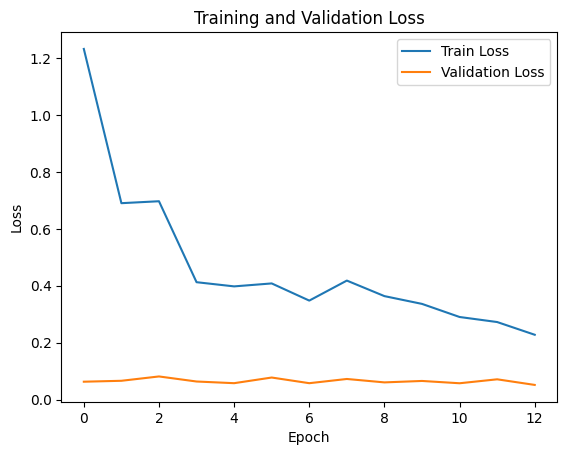

In [234]:
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [235]:
correct = 0
total = 0
with torch.no_grad():
    for features, labels in test_loader:
        features, labels = features.to(device), labels.to(device)
        predictions = model(features)
        _, predicted_labels = torch.max(predictions, 1)  # Get the predicted class labels
        correct += (predicted_labels == labels).sum().item()
        total += labels.size(0)

# Calculate the accuracy by dividing the number of correct predictions by the total number of predictions
accuracy = (correct / total)*100
print(f"Accuracy: {accuracy}")

Accuracy: 90.0
